# Chapter 4: Monte Carlo Methods

This notebook demonstrates Monte Carlo methods for reinforcement learning.

## 🚀 Google Colab Ready
**Run the setup cell below first to install all dependencies!**

## Contents:
1. [Setup and Installation](#setup)
2. [Monte Carlo Policy Evaluation](#mc-evaluation)
3. [First-visit vs Every-visit MC](#first-vs-every)
4. [Monte Carlo Control](#mc-control)
5. [Off-policy Monte Carlo](#off-policy-mc)
6. [Importance Sampling](#importance-sampling)
7. [OpenAI Gym: Blackjack](#gym-blackjack)

---

## Setup and Installation <a id="setup"></a>

**🔧 Google Colab Setup - Run this cell first!**

In [1]:
# 🔧 Google Colab Setup - Run this cell first!
print("🚀 Setting up Monte Carlo Methods environment...")

# Install required packages
!pip install gymnasium[classic_control] --quiet
!pip install gym --quiet
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install tqdm --quiet

print("✅ Packages installed successfully!")

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Handle gym/gymnasium import
try:
    import gymnasium as gym
    print("✅ Using Gymnasium (new OpenAI Gym)")
except ImportError:
    try:
        import gym
        print("✅ Using legacy OpenAI Gym")
    except ImportError:
        print("🔧 Installing gym packages...")
        !pip install gym gymnasium --quiet
        import gymnasium as gym
        print("✅ Gym installed and imported successfully")

# Utility functions for cross-platform compatibility
def safe_env_reset(env):
    """Safely reset environment with compatibility for old/new Gym versions."""
    try:
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            return reset_result[0], reset_result[1]  # state, info
        else:
            return reset_result, {}  # state, empty info
    except Exception as e:
        print(f"⚠️ Environment reset failed: {e}")
        return 0, {}

def safe_env_step(env, action):
    """Safely step environment with compatibility for old/new Gym versions."""
    try:
        step_result = env.step(action)
        if len(step_result) == 5:  # New Gym version (gymnasium)
            next_state, reward, terminated, truncated, info = step_result
            done = terminated or truncated
            return next_state, reward, done, info
        elif len(step_result) == 4:  # Old Gym version
            next_state, reward, done, info = step_result
            return next_state, reward, done, info
        else:
            raise ValueError(f"Unexpected step result length: {len(step_result)}")
    except Exception as e:
        print(f"⚠️ Environment step failed: {e}")
        return 0, 0, True, {}

# Set random seed and configure plots
np.random.seed(42)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")

# Test environment
try:
    test_env = gym.make('FrozenLake-v1', render_mode=None)
    print(f"✅ Environment test successful!")
    test_env.close()
except Exception as e:
    print(f"⚠️ Environment test failed: {e}")

print("🎉 Setup complete! Ready for Monte Carlo methods!")

🚀 Setting up Monte Carlo Methods environment...
✅ Packages installed successfully!
✅ Using Gymnasium (new OpenAI Gym)
✅ Environment test successful!
🎉 Setup complete! Ready for Monte Carlo methods!


## 1. Monte Carlo Policy Evaluation <a id="mc-evaluation"></a>

MC estimates value functions by averaging returns:
$V^\pi(s) \approx \frac{1}{n} \sum_{i=1}^n G_i(s)$

Running First-visit MC...


MC Evaluation: 100%|██████████| 5000/5000 [00:09<00:00, 550.62it/s]


Running Every-visit MC...


Every-visit MC: 100%|██████████| 5000/5000 [00:18<00:00, 269.93it/s]


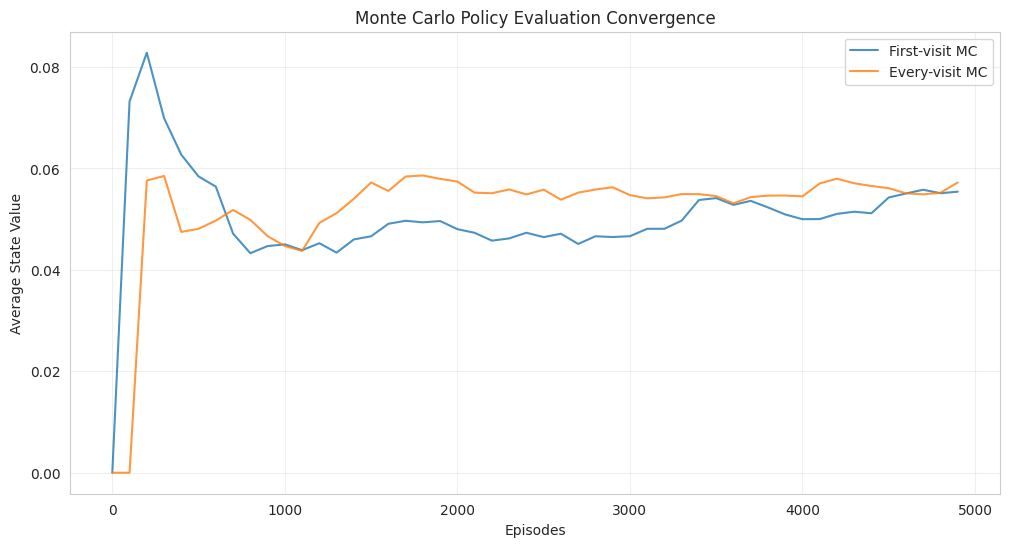

Final average value (First-visit): 0.0554
Final average value (Every-visit): 0.0572


In [2]:
class MonteCarloAgent:
    """Monte Carlo agent for policy evaluation and control."""

    def __init__(self, n_states, n_actions, gamma=0.9):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma

        # Value function estimates
        self.V = defaultdict(float)
        self.Q = defaultdict(lambda: defaultdict(float))

        # Visit counts
        self.state_visits = defaultdict(int)
        self.state_action_visits = defaultdict(lambda: defaultdict(int))

        # Return sums
        self.state_returns = defaultdict(list)
        self.state_action_returns = defaultdict(lambda: defaultdict(list))

    def generate_episode(self, env, policy):
        """Generate an episode following given policy."""
        episode = []

        # Handle both old and new Gym versions
        reset_result = env.reset()
        if isinstance(reset_result, tuple):
            state, _ = reset_result
        else:
            state = reset_result

        while True:
            if callable(policy):
                action = policy(state)
            else:
                action = policy[state]

            step_result = env.step(action)
            if len(step_result) == 5:  # New Gym version
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:  # Old Gym version
                next_state, reward, done, _ = step_result

            episode.append((state, action, reward))

            if done:
                break
            state = next_state

        return episode

    def first_visit_mc_evaluation(self, env, policy, num_episodes=10000):
        """First-visit Monte Carlo policy evaluation."""
        value_history = []

        for episode_num in tqdm(range(num_episodes), desc="MC Evaluation"):
            episode = self.generate_episode(env, policy)

            # Calculate returns for each state-action pair
            G = 0
            visited_states = set()

            # Traverse episode backwards
            for i in reversed(range(len(episode))):
                state, action, reward = episode[i]
                G = self.gamma * G + reward

                # First-visit: only update if state not seen before in this episode
                if state not in visited_states:
                    visited_states.add(state)

                    self.state_returns[state].append(G)
                    self.state_visits[state] += 1

                    # Update value estimate (incremental mean)
                    self.V[state] = np.mean(self.state_returns[state])

            # Store value history for convergence analysis
            if episode_num % 100 == 0:
                avg_value = np.mean([self.V[s] for s in range(self.n_states)])
                value_history.append(avg_value)

        return value_history

    def every_visit_mc_evaluation(self, env, policy, num_episodes=10000):
        """Every-visit Monte Carlo policy evaluation."""
        # Reset for fair comparison
        self.V = defaultdict(float)
        self.state_returns = defaultdict(list)

        value_history = []

        for episode_num in tqdm(range(num_episodes), desc="Every-visit MC"):
            episode = self.generate_episode(env, policy)

            # Calculate returns
            returns = []
            G = 0
            for i in reversed(range(len(episode))):
                state, action, reward = episode[i]
                G = self.gamma * G + reward
                returns.append((state, G))

            # Every-visit: update for every occurrence
            for state, G in reversed(returns):
                self.state_returns[state].append(G)
                self.V[state] = np.mean(self.state_returns[state])

            if episode_num % 100 == 0:
                avg_value = np.mean([self.V[s] for s in range(self.n_states)])
                value_history.append(avg_value)

        return value_history

# Test MC evaluation on a simple environment
env = gym.make('FrozenLake-v1', is_slippery=False, render_mode=None)

# Random policy
def random_policy(state):
    return np.random.choice(env.action_space.n)

# Create MC agent
mc_agent = MonteCarloAgent(env.observation_space.n, env.action_space.n)

# Compare first-visit vs every-visit
print("Running First-visit MC...")
history_first = mc_agent.first_visit_mc_evaluation(env, random_policy, num_episodes=5000)

mc_agent_every = MonteCarloAgent(env.observation_space.n, env.action_space.n)
print("Running Every-visit MC...")
history_every = mc_agent_every.every_visit_mc_evaluation(env, random_policy, num_episodes=5000)

# Plot convergence comparison
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(history_first)*100, 100), history_first, label='First-visit MC', alpha=0.8)
plt.plot(range(0, len(history_every)*100, 100), history_every, label='Every-visit MC', alpha=0.8)
plt.xlabel('Episodes')
plt.ylabel('Average State Value')
plt.title('Monte Carlo Policy Evaluation Convergence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final average value (First-visit): {history_first[-1]:.4f}")
print(f"Final average value (Every-visit): {history_every[-1]:.4f}")

## 2. Monte Carlo Control <a id="mc-control"></a>

MC control learns optimal policy using ε-greedy exploration and Q-value updates.

Running Monte Carlo Control...


MC Control: 100%|██████████| 20000/20000 [00:59<00:00, 338.48it/s]



Learned policy performance:
Mean reward: 0.168 ± 0.374
Success rate: 16.8%


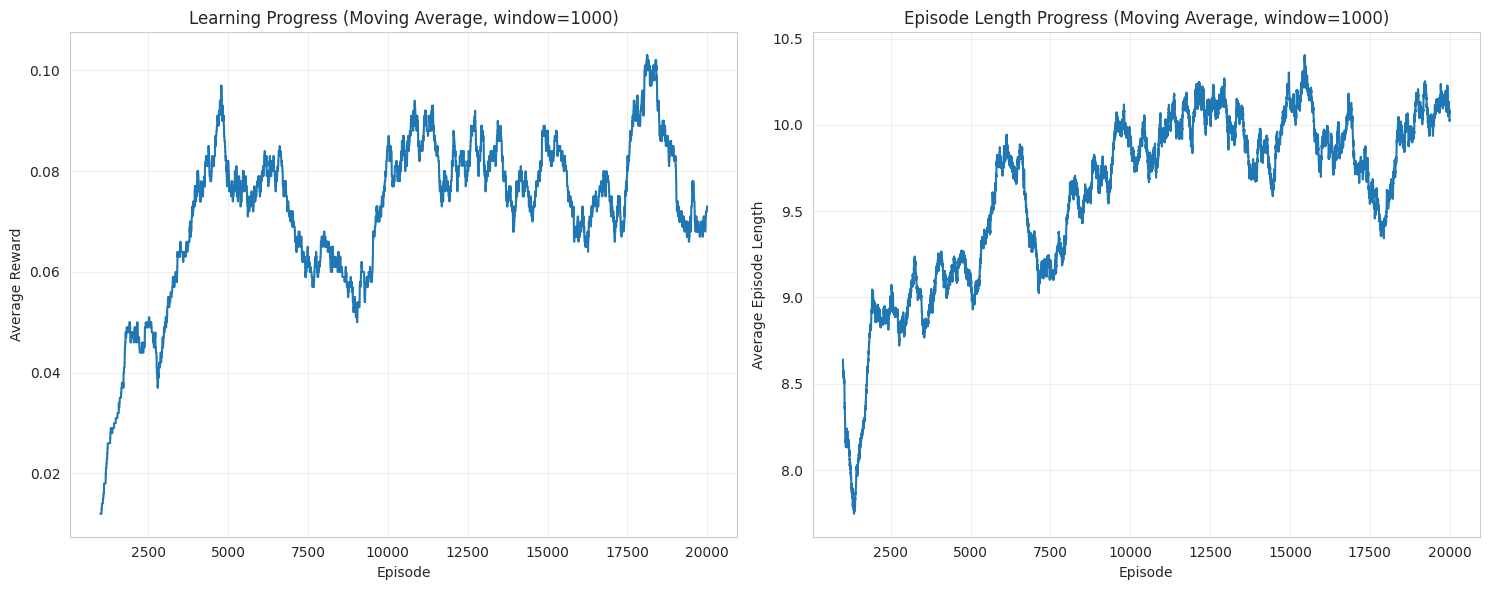

In [3]:
class MCControlAgent:
    """Monte Carlo Control with ε-greedy exploration."""

    def __init__(self, n_states, n_actions, gamma=0.9, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon

        # Q-values and visit counts
        self.Q = defaultdict(lambda: defaultdict(float))
        self.returns = defaultdict(lambda: defaultdict(list))
        self.policy = defaultdict(int)

    def epsilon_greedy_policy(self, state):
        """ε-greedy action selection."""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            q_values = [self.Q[state][a] for a in range(self.n_actions)]
            return np.argmax(q_values)

    def update_policy(self, state):
        """Update policy to be greedy w.r.t. current Q-values."""
        q_values = [self.Q[state][a] for a in range(self.n_actions)]
        self.policy[state] = np.argmax(q_values)

    def mc_control(self, env, num_episodes=10000):
        """Monte Carlo control algorithm."""
        episode_rewards = []
        episode_lengths = []

        for episode_num in tqdm(range(num_episodes), desc="MC Control"):
            # Generate episode using current ε-greedy policy
            episode = []
            state, _ = safe_env_reset(env)
            total_reward = 0

            while True:
                action = self.epsilon_greedy_policy(state)
                next_state, reward, done, _ = safe_env_step(env, action)
                episode.append((state, action, reward))
                total_reward += reward

                if done:
                    break
                state = next_state

            episode_rewards.append(total_reward)
            episode_lengths.append(len(episode))

            # Update Q-values using first-visit MC
            G = 0
            visited_state_actions = set()

            for i in reversed(range(len(episode))):
                state, action, reward = episode[i]
                G = self.gamma * G + reward

                state_action = (state, action)
                if state_action not in visited_state_actions:
                    visited_state_actions.add(state_action)

                    self.returns[state][action].append(G)
                    self.Q[state][action] = np.mean(self.returns[state][action])

                    # Update policy
                    self.update_policy(state)

            # Decay epsilon
            if episode_num % 1000 == 0 and self.epsilon > 0.01:
                self.epsilon *= 0.99

        return episode_rewards, episode_lengths

    def test_policy(self, env, num_episodes=100):
        """Test learned policy."""
        test_rewards = []

        for _ in range(num_episodes):
            state, _ = safe_env_reset(env)
            total_reward = 0

            while True:
                # Use greedy policy (epsilon=0)
                q_values = [self.Q[state][a] for a in range(self.n_actions)]
                action = np.argmax(q_values)

                state, reward, done, _ = safe_env_step(env, action)
                total_reward += reward

                if done:
                    break

            test_rewards.append(total_reward)

        return np.mean(test_rewards), np.std(test_rewards)

# Run MC Control on FrozenLake
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode=None)  # Slippery version
mc_control_agent = MCControlAgent(env.observation_space.n, env.action_space.n, epsilon=0.3)

print("Running Monte Carlo Control...")
rewards, lengths = mc_control_agent.mc_control(env, num_episodes=20000)

# Test learned policy
mean_reward, std_reward = mc_control_agent.test_policy(env, num_episodes=1000)
print(f"\nLearned policy performance:")
print(f"Mean reward: {mean_reward:.3f} ± {std_reward:.3f}")
print(f"Success rate: {mean_reward:.1%}")

# Plot learning progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Moving average of rewards
window = 1000
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(rewards)), moving_avg)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Average Reward')
ax1.set_title(f'Learning Progress (Moving Average, window={window})')
ax1.grid(True, alpha=0.3)

# Episode lengths
moving_avg_lengths = np.convolve(lengths, np.ones(window)/window, mode='valid')
ax2.plot(range(window-1, len(lengths)), moving_avg_lengths)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Average Episode Length')
ax2.set_title(f'Episode Length Progress (Moving Average, window={window})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Off-policy Monte Carlo with Importance Sampling <a id="off-policy-mc"></a>

Learn about target policy π while following behavior policy μ using importance sampling.

Running Off-policy Monte Carlo...


Off-policy MC: 100%|██████████| 15000/15000 [00:07<00:00, 2055.68it/s]



Performance Comparison:
On-policy MC:  0.156 ± 0.363
Off-policy MC: 0.137 ± 0.344


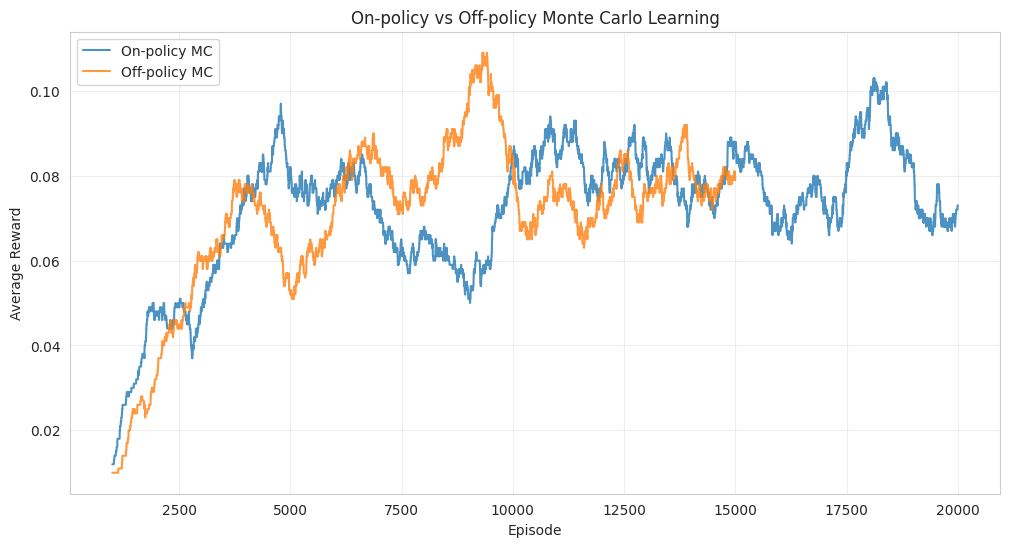

In [4]:
class OffPolicyMC:
    """Off-policy Monte Carlo with importance sampling."""

    def __init__(self, n_states, n_actions, gamma=0.9):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma

        # Q-values for target policy
        self.Q = defaultdict(lambda: defaultdict(float))

        # Cumulative importance ratios
        self.C = defaultdict(lambda: defaultdict(float))

        # Target policy (greedy)
        self.target_policy = defaultdict(int)

    def behavior_policy(self, state, epsilon=0.5):
        """ε-greedy behavior policy."""
        if np.random.random() < epsilon:
            return np.random.choice(self.n_actions)
        else:
            q_values = [self.Q[state][a] for a in range(self.n_actions)]
            return np.argmax(q_values)

    def get_behavior_prob(self, state, action, epsilon=0.5):
        """Get probability of action under behavior policy."""
        q_values = [self.Q[state][a] for a in range(self.n_actions)]
        greedy_action = np.argmax(q_values)

        if action == greedy_action:
            return 1 - epsilon + epsilon / self.n_actions
        else:
            return epsilon / self.n_actions

    def get_target_prob(self, state, action):
        """Get probability of action under target policy (greedy)."""
        q_values = [self.Q[state][a] for a in range(self.n_actions)]
        greedy_action = np.argmax(q_values)
        return 1.0 if action == greedy_action else 0.0

    def off_policy_mc_control(self, env, num_episodes=10000, epsilon=0.3):
        """Off-policy MC control with weighted importance sampling."""
        episode_rewards = []

        for episode_num in tqdm(range(num_episodes), desc="Off-policy MC"):
            # Generate episode using behavior policy
            episode = []
            state, _ = safe_env_reset(env)
            total_reward = 0

            while True:
                action = self.behavior_policy(state, epsilon)
                next_state, reward, done, _ = safe_env_step(env, action)
                episode.append((state, action, reward))
                total_reward += reward

                if done:
                    break
                state = next_state

            episode_rewards.append(total_reward)

            # Update Q-values using weighted importance sampling
            G = 0
            W = 1.0  # Importance ratio

            for i in reversed(range(len(episode))):
                state, action, reward = episode[i]
                G = self.gamma * G + reward

                # Update cumulative weights and Q-values
                self.C[state][action] += W
                if self.C[state][action] > 0:
                    self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])

                # Update target policy to be greedy
                q_values = [self.Q[state][a] for a in range(self.n_actions)]
                self.target_policy[state] = np.argmax(q_values)

                # Check if action is consistent with target policy
                if action != self.target_policy[state]:
                    break  # Trajectory no longer relevant

                # Update importance ratio
                behavior_prob = self.get_behavior_prob(state, action, epsilon)
                target_prob = self.get_target_prob(state, action)

                if behavior_prob > 0:
                    W *= target_prob / behavior_prob
                else:
                    break

        return episode_rewards

    def test_target_policy(self, env, num_episodes=100):
        """Test the learned target policy."""
        test_rewards = []

        for _ in range(num_episodes):
            state, _ = safe_env_reset(env)
            total_reward = 0

            while True:
                action = self.target_policy[state]
                state, reward, done, _ = safe_env_step(env, action)
                total_reward += reward

                if done:
                    break

            test_rewards.append(total_reward)

        return np.mean(test_rewards), np.std(test_rewards)

# Compare on-policy vs off-policy MC
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode=None)

# Off-policy MC
off_policy_agent = OffPolicyMC(env.observation_space.n, env.action_space.n)
print("Running Off-policy Monte Carlo...")
off_policy_rewards = off_policy_agent.off_policy_mc_control(env, num_episodes=15000)

# Test both policies
on_policy_perf = mc_control_agent.test_policy(env, num_episodes=1000)
off_policy_perf = off_policy_agent.test_target_policy(env, num_episodes=1000)

print(f"\nPerformance Comparison:")
print(f"On-policy MC:  {on_policy_perf[0]:.3f} ± {on_policy_perf[1]:.3f}")
print(f"Off-policy MC: {off_policy_perf[0]:.3f} ± {off_policy_perf[1]:.3f}")

# Plot learning comparison
plt.figure(figsize=(12, 6))
window = 1000

# On-policy learning curve
on_policy_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(rewards)), on_policy_avg, label='On-policy MC', alpha=0.8)

# Off-policy learning curve
off_policy_avg = np.convolve(off_policy_rewards, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(off_policy_rewards)), off_policy_avg, label='Off-policy MC', alpha=0.8)

plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('On-policy vs Off-policy Monte Carlo Learning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. OpenAI Gym: Blackjack Environment <a id="gym-blackjack"></a>

Blackjack is a classic MC environment with large state space and episodic structure.

Training Blackjack agent...


Blackjack MC: 100%|██████████| 300000/300000 [03:40<00:00, 1359.31it/s]


Training win rate: 0.415
Test win rate: 0.431
Test average reward: -0.050


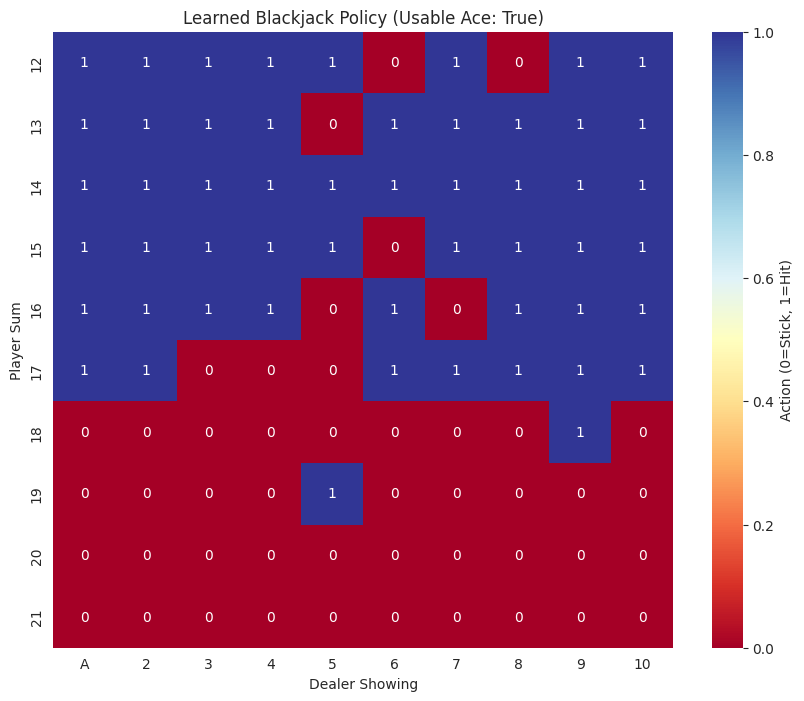

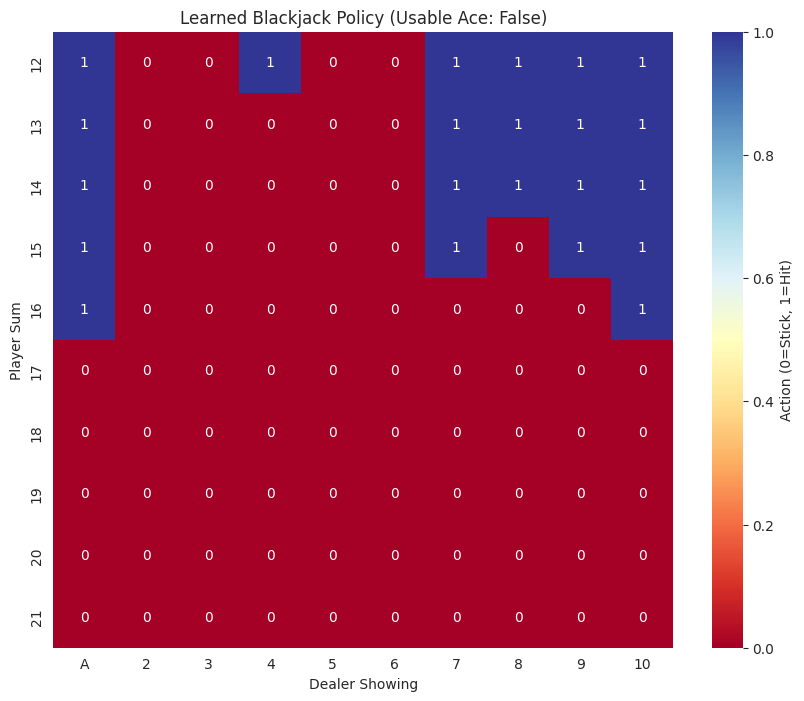

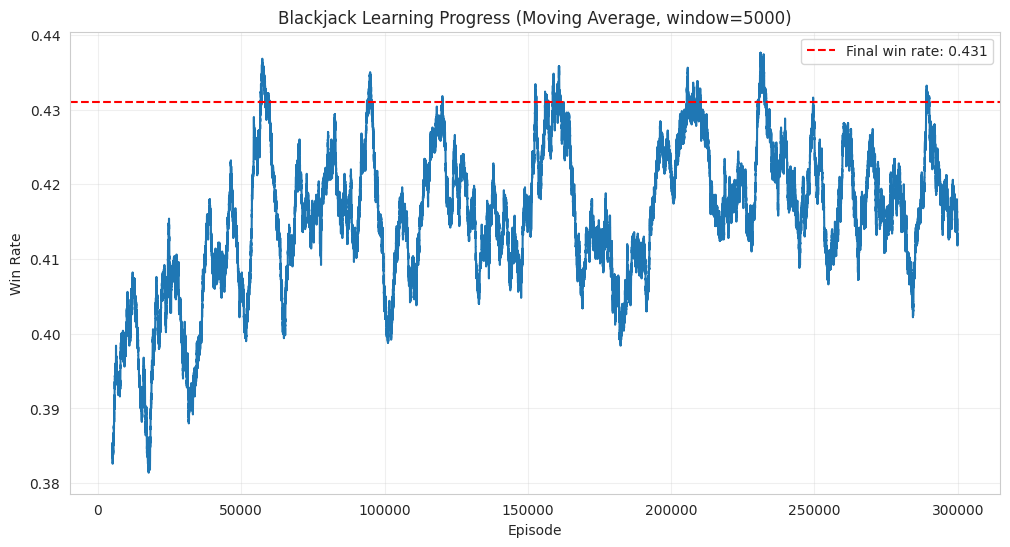

In [5]:
class BlackjackMC:
    """Monte Carlo for Blackjack environment."""

    def __init__(self, gamma=1.0):
        self.gamma = gamma
        self.Q = defaultdict(lambda: defaultdict(float))
        self.returns = defaultdict(lambda: defaultdict(list))
        self.policy = defaultdict(int)

        # Initialize with basic strategy approximation
        self._initialize_policy()

    def _initialize_policy(self):
        """Initialize with basic strategy heuristic."""
        for player_sum in range(12, 22):  # Player sum 12-21
            for dealer_card in range(1, 11):  # Dealer showing 1-10
                for usable_ace in [True, False]:
                    state = (player_sum, dealer_card, usable_ace)

                    # Basic strategy: hit if sum < 17, stick otherwise
                    if player_sum < 17:
                        self.policy[state] = 1  # Hit
                    else:
                        self.policy[state] = 0  # Stick

    def epsilon_greedy_action(self, state, epsilon=0.1):
        """ε-greedy action selection."""
        if np.random.random() < epsilon:
            return np.random.choice(2)  # Random action (0=stick, 1=hit)
        else:
            q_stick = self.Q[state][0]
            q_hit = self.Q[state][1]
            return 0 if q_stick >= q_hit else 1

    def mc_control_blackjack(self, num_episodes=500000, epsilon=0.1):
        """Monte Carlo control for Blackjack."""
        env = gym.make('Blackjack-v1', render_mode=None)

        episode_rewards = []
        wins = 0

        for episode in tqdm(range(num_episodes), desc="Blackjack MC"):
            # Generate episode
            trajectory = []
            state, _ = safe_env_reset(env)

            while True:
                action = self.epsilon_greedy_action(state, epsilon)
                next_state, reward, done, _ = safe_env_step(env, action)
                trajectory.append((state, action, reward))

                if done:
                    if reward > 0:
                        wins += 1
                    break

                state = next_state

            episode_rewards.append(reward)

            # Update Q-values using first-visit MC
            G = 0
            visited_state_actions = set()

            for i in reversed(range(len(trajectory))):
                state, action, reward = trajectory[i]
                G = self.gamma * G + reward

                state_action = (state, action)
                if state_action not in visited_state_actions:
                    visited_state_actions.add(state_action)

                    self.returns[state][action].append(G)
                    self.Q[state][action] = np.mean(self.returns[state][action])

                    # Update policy to be greedy
                    q_stick = self.Q[state][0]
                    q_hit = self.Q[state][1]
                    self.policy[state] = 0 if q_stick >= q_hit else 1

            # Decay epsilon
            if episode % 10000 == 0 and epsilon > 0.01:
                epsilon *= 0.99

        win_rate = wins / num_episodes
        return episode_rewards, win_rate

    def visualize_policy(self, usable_ace=True):
        """Visualize the learned policy."""
        policy_grid = np.zeros((10, 10))  # Player sum 12-21, Dealer 1-10

        for player_sum in range(12, 22):
            for dealer_card in range(1, 11):
                state = (player_sum, dealer_card, usable_ace)
                policy_grid[player_sum - 12, dealer_card - 1] = self.policy[state]

        plt.figure(figsize=(10, 8))
        sns.heatmap(policy_grid,
                   xticklabels=[f'A' if i == 0 else str(i+1) for i in range(10)],
                   yticklabels=range(12, 22),
                   cmap='RdYlBu', center=0.5,
                   cbar_kws={'label': 'Action (0=Stick, 1=Hit)'},
                   annot=True, fmt='.0f')
        plt.title(f'Learned Blackjack Policy (Usable Ace: {usable_ace})')
        plt.xlabel('Dealer Showing')
        plt.ylabel('Player Sum')
        plt.show()

    def test_policy(self, num_episodes=10000):
        """Test the learned policy."""
        env = gym.make('Blackjack-v1', render_mode=None)
        wins = 0
        total_reward = 0

        for _ in range(num_episodes):
            state, _ = safe_env_reset(env)

            while True:
                action = self.policy[state]
                state, reward, done, _ = safe_env_step(env, action)

                if done:
                    if reward > 0:
                        wins += 1
                    total_reward += reward
                    break

        return wins / num_episodes, total_reward / num_episodes

# Train Blackjack agent
blackjack_agent = BlackjackMC()
print("Training Blackjack agent...")
rewards, training_win_rate = blackjack_agent.mc_control_blackjack(num_episodes=300000)

print(f"Training win rate: {training_win_rate:.3f}")

# Test learned policy
test_win_rate, test_avg_reward = blackjack_agent.test_policy(num_episodes=100000)
print(f"Test win rate: {test_win_rate:.3f}")
print(f"Test average reward: {test_avg_reward:.3f}")

# Visualize learned policies
blackjack_agent.visualize_policy(usable_ace=True)
blackjack_agent.visualize_policy(usable_ace=False)

# Plot learning progress
plt.figure(figsize=(12, 6))
window = 5000
win_rate_moving = np.convolve([1 if r > 0 else 0 for r in rewards],
                             np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(rewards)), win_rate_moving)
plt.axhline(test_win_rate, color='red', linestyle='--',
           label=f'Final win rate: {test_win_rate:.3f}')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.title(f'Blackjack Learning Progress (Moving Average, window={window})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()